In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/no_hashtags.csv')

data.loc[data['target']!=2, 'target'] = 0
data.loc[data['target']==2, 'target'] = 1

In [3]:
from sklearn.model_selection import train_test_split
X = data['text']
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=112221, stratify=y)

# Baseline Model

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
 
tfidf = TfidfVectorizer()
baseline_model = LogisticRegression(max_iter=1000, random_state=112221)

baseline_pipeline = Pipeline(steps=[('tfidf', tfidf), ('baseline', baseline_model)])
baseline_pipeline.fit(X_train, y_train)

baseline_y_pred = baseline_pipeline.predict(X_test)
accuracy_score(y_test, baseline_y_pred)

0.7317719840919134

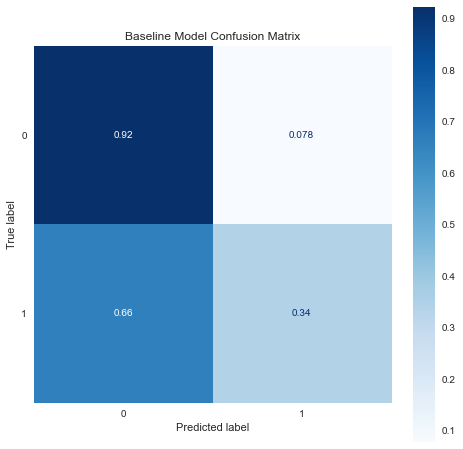

In [8]:
from sklearn.metrics import plot_confusion_matrix
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(baseline_pipeline, X_test, y_test, ax=ax, normalize='true', cmap='Blues')
plt.title('Baseline Model Confusion Matrix')
plt.grid(False)
plt.show()

In [11]:
from sklearn.model_selection import GridSearchCV

lr_grid = {'baseline__C':[0.001, 0.1, 1], 'baseline__solver':['lbfgs', 'saga'], 'baseline__fit_intercept':[True, False]}
lr_gridsearch = GridSearchCV(estimator=baseline_pipeline, param_grid=lr_grid, scoring='accuracy', cv=5)
lr_gridsearch.fit(X_train, y_train)

print(f'Cross validation scores: {lr_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {lr_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {lr_gridsearch.best_params_}')

Cross validation scores: [0.6724621  0.6724621  0.6724621  0.6724621  0.67865049 0.67865049
 0.68660727 0.68660727 0.73331344 0.73287139 0.73316594 0.73316594]
Best cross validation score: 73.33%
Optimal parameters: {'baseline__C': 1, 'baseline__fit_intercept': True, 'baseline__solver': 'lbfgs'}


# Decision Tree

In [12]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=112221)

dt_pipeline = Pipeline(steps=[('tfidf', tfidf), ('dt', dt_model)])
dt_pipeline.fit(X_train, y_train)

dt_y_pred = dt_pipeline.predict(X_test)
accuracy_score(y_test, dt_y_pred)

0.6924436588599204

In [13]:
dt_grid = {
    'dt__criterion':['gini', 'entropy'],
    'dt__splitter':['best', 'random'],
    'dt__max_depth':[2, 6, 10, 15],
    'dt__min_samples_split': [5, 10],
    'dt__min_samples_leaf': [3, 6],
}

dt_gridsearch = GridSearchCV(estimator=dt_pipeline, param_grid=dt_grid, scoring='accuracy', cv=5)
dt_gridsearch.fit(X_train, y_train)

print(f'Cross validation scores: {dt_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {dt_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {dt_gridsearch.best_params_}')

Cross validation scores: [0.68071311 0.68395469 0.68071311 0.68395469 0.68071289 0.68424935
 0.68071289 0.68424935 0.6948586  0.69485643 0.69485849 0.69441428
 0.69397408 0.69338368 0.69397408 0.69338368 0.69957261 0.6989822
 0.69942533 0.69927719 0.69942555 0.69721436 0.69942555 0.69721436
 0.69412049 0.70148773 0.69176365 0.70222237 0.69397321 0.70075222
 0.69397321 0.70075222 0.68071311 0.68410196 0.68071311 0.68410196
 0.6814497  0.68424935 0.6814497  0.68424935 0.69441721 0.6927936
 0.69426983 0.6927936  0.69544814 0.69338346 0.69544814 0.69338346
 0.69736261 0.69441374 0.69706773 0.69780302 0.69780574 0.69839256
 0.69780574 0.69839256 0.69043871 0.69971912 0.69191157 0.70355056
 0.69250078 0.69809692 0.69250078 0.69809692]
Best cross validation score: 70.36%
Optimal parameters: {'dt__criterion': 'entropy', 'dt__max_depth': 15, 'dt__min_samples_leaf': 3, 'dt__min_samples_split': 10, 'dt__splitter': 'random'}


In [14]:
tuned_dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=3, min_samples_split=10, splitter='random', random_state=112221)

tuned_dt_pipeline = Pipeline(steps=[('tfidf', tfidf), ('tuned_dt', tuned_dt_model)])
tuned_dt_pipeline.fit(X_train, y_train)

tuned_dt_y_pred = tuned_dt_pipeline.predict(X_test)
accuracy_score(y_test, tuned_dt_y_pred)

0.7052585064074238

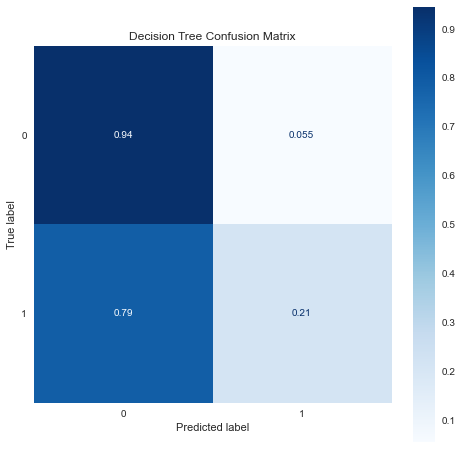

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(tuned_dt_pipeline, X_test, y_test, ax=ax, normalize='true', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.grid(False)
plt.show()

# Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

In [17]:
rf_model = RandomForestClassifier(random_state=112221)

rf_pipeline = Pipeline(steps=[('tfidf', tfidf), ('rf', rf_model)])
rf_pipeline.fit(X_train, y_train)

rf_y_pred = rf_pipeline.predict(X_test)
accuracy_score(y_test, rf_y_pred)

0.7476800707026071

In [18]:
rf_grid = {
    'rf__n_estimators':[10, 30, 100],
    'rf__criterion':['gini', 'entropy'],
    'rf__max_depth':[None, 2, 6, 10],
    'rf__min_samples_split':[5, 10],
    'rf__min_samples_leaf':[3, 6]
}

rf_gridsearch = GridSearchCV(estimator=rf_pipeline, param_grid=rf_grid, scoring='accuracy', cv=5)
rf_gridsearch.fit(X_train, y_train)

print(f'Cross validation scores: {rf_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {rf_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {rf_gridsearch.best_params_}')

Cross validation scores: [0.70163587 0.71312824 0.71401265 0.70605511 0.71784301 0.71415982
 0.70045702 0.69765738 0.69471089 0.70045702 0.69765738 0.69471089
 0.6724621  0.6724621  0.6724621  0.6724621  0.6724621  0.6724621
 0.6724621  0.6724621  0.6724621  0.6724621  0.6724621  0.6724621
 0.6743781  0.67452494 0.67452494 0.67408333 0.67467221 0.67452494
 0.67437766 0.67570314 0.67437755 0.67437766 0.67570314 0.67437755
 0.68144927 0.67982826 0.67909178 0.68144916 0.67968099 0.67864973
 0.6805654  0.67968131 0.67850246 0.6805654  0.67968131 0.67850246
 0.70546699 0.71666448 0.71681143 0.70428737 0.71607516 0.71592843
 0.70148665 0.70266637 0.69647798 0.70148665 0.70266637 0.69647798
 0.6724621  0.6724621  0.6724621  0.6724621  0.6724621  0.6724621
 0.6724621  0.6724621  0.6724621  0.6724621  0.6724621  0.6724621
 0.67393594 0.67585096 0.674083   0.67378856 0.67570368 0.67408311
 0.67496698 0.67511404 0.67423039 0.67496698 0.67511404 0.67423039
 0.67997597 0.67923905 0.67835518 0.67968

In [21]:
rf_tuned_grid = {
    'rf__max_depth': [None, 8, 12], 
    'rf__min_samples_leaf':[1, 2, 3], 
    'rf__min_samples_split': [10, 15], 
    'rf__n_estimators': [20, 30, 50]
}

rf_tuned_gridsearch = GridSearchCV(estimator=rf_pipeline, param_grid=rf_tuned_grid, scoring='accuracy', cv=5)
rf_tuned_gridsearch.fit(X_train, y_train)

print(f'Cross validation scores: {rf_tuned_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {rf_tuned_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {rf_tuned_gridsearch.best_params_}')

Cross validation scores: [0.71990258 0.72270266 0.72447105 0.72108339 0.72756514 0.72771371
 0.71740031 0.72373619 0.7238839  0.71725217 0.72049505 0.72668387
 0.71047641 0.71784301 0.71607397 0.71342279 0.71401168 0.71312802
 0.67820769 0.67879733 0.67761826 0.67835507 0.67879733 0.67761826
 0.67835518 0.67835529 0.67791303 0.67761859 0.67879701 0.67732349
 0.67835518 0.67850257 0.67835507 0.67747131 0.67894439 0.67791303
 0.68174393 0.68085984 0.68100733 0.68115461 0.68071235 0.68056518
 0.68071267 0.68027041 0.68012314 0.6804178  0.67968088 0.67938633
 0.68130188 0.68085995 0.6804178  0.68100733 0.67968088 0.67982859]
Best cross validation score: 72.77%
Optimal parameters: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 15, 'rf__n_estimators': 50}


In [22]:
rf_tuned_grid_1 = {  
    'rf__min_samples_split': [15], 
    'rf__n_estimators': [50,70]
}

rf_tuned_gridsearch_1 = GridSearchCV(estimator=rf_pipeline, param_grid=rf_tuned_grid_1, scoring='accuracy', cv=5)
rf_tuned_gridsearch_1.fit(X_train, y_train)

print(f'Cross validation scores: {rf_tuned_gridsearch_1.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {rf_tuned_gridsearch_1.best_score_ :.2%}')
print(f'Optimal parameters: {rf_tuned_gridsearch_1.best_params_}')

Cross validation scores: [0.72771371 0.72638737]
Best cross validation score: 72.77%
Optimal parameters: {'rf__min_samples_split': 15, 'rf__n_estimators': 50}


In [24]:
tuned_rf_model = RandomForestClassifier(min_samples_split=15, n_estimators=50, random_state=112221)

tuned_rf_pipeline = Pipeline(steps=[('tfidf', tfidf), ('tuned_rf', tuned_rf_model)])
tuned_rf_pipeline.fit(X_train, y_train)

tuned_rf_y_pred = tuned_rf_pipeline.predict(X_test)
accuracy_score(y_test, tuned_rf_y_pred)

0.7419354838709677

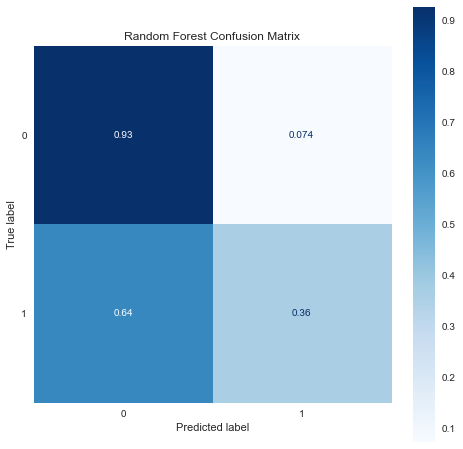

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(tuned_rf_pipeline, X_test, y_test, ax=ax, normalize='true', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.grid(False)
plt.show()

# Extra Trees

In [26]:
et_model = ExtraTreesClassifier(random_state=112221)

et_pipeline = Pipeline(steps=[('tfidf', tfidf), ('et', et_model)])
et_pipeline.fit(X_train, y_train)

et_y_pred = rf_pipeline.predict(X_test)
accuracy_score(y_test, et_y_pred)

0.7476800707026071

In [27]:
et_grid = {
    'et__n_estimators':[10, 30, 100],
    'et__criterion':['gini', 'entropy'],
    'et__max_depth':[None, 2, 6, 10],
    'et__min_samples_split':[5, 10],
    'et__min_samples_leaf':[3, 6]
}

et_gridsearch = GridSearchCV(estimator=et_pipeline, param_grid=et_grid, scoring='accuracy', cv=5)
et_gridsearch.fit(X_train, y_train)

print(f'Cross validation scores: {et_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {et_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {et_gridsearch.best_params_}')

Cross validation scores: [0.71356898 0.71872557 0.71975748 0.71666459 0.72240985 0.72049407
 0.69824821 0.69647939 0.69603702 0.69824821 0.69647939 0.69603702
 0.6724621  0.6724621  0.6724621  0.6724621  0.6724621  0.6724621
 0.6724621  0.6724621  0.6724621  0.6724621  0.6724621  0.6724621
 0.67349379 0.67334619 0.6724621  0.67349379 0.67334619 0.6724621
 0.67408333 0.67319902 0.6724621  0.67408333 0.67319902 0.6724621
 0.67614562 0.67614573 0.6757039  0.67629289 0.67585096 0.67511436
 0.67599921 0.67526218 0.67482025 0.67599921 0.67526218 0.67482025
 0.71843222 0.72373684 0.72137968 0.7196114  0.72314709 0.71902186
 0.6989822  0.69883428 0.69706719 0.6989822  0.69883428 0.69706719
 0.6724621  0.6724621  0.6724621  0.6724621  0.6724621  0.6724621
 0.6724621  0.6724621  0.6724621  0.6724621  0.6724621  0.6724621
 0.67423071 0.67334619 0.67260949 0.67423071 0.67334619 0.67275687
 0.6743781  0.67319881 0.67260949 0.6743781  0.67319881 0.67260949
 0.67658788 0.67643984 0.67526153 0.6764404

In [28]:
et_tuned_grid = {
    'et__n_estimators':[20, 30, 50],
    'et__min_samples_split':[3, 5, 8],
    'et__min_samples_leaf':[1, 2, 3]
}

et_tuned_gridsearch = GridSearchCV(estimator=et_pipeline, param_grid=et_tuned_grid, scoring='accuracy', cv=5)
et_tuned_gridsearch.fit(X_train, y_train)

print(f'Cross validation scores: {et_tuned_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {et_tuned_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {et_tuned_gridsearch.best_params_}')

Cross validation scores: [0.73257619 0.73154472 0.7290406  0.72948156 0.73360766 0.73640741
 0.73257673 0.73478652 0.73404992 0.72609347 0.73228197 0.72786175
 0.72447268 0.7278611  0.72727297 0.72550393 0.72771415 0.72874584
 0.7212311  0.71872557 0.71857938 0.7212311  0.71872557 0.71857938
 0.71887307 0.72064189 0.71902121]
Best cross validation score: 73.64%
Optimal parameters: {'et__min_samples_leaf': 1, 'et__min_samples_split': 5, 'et__n_estimators': 50}


In [29]:
et_tuned_grid = {
    'et__n_estimators':[50, 75, 85],
    'et__min_samples_split':[5],
}

et_tuned_gridsearch = GridSearchCV(estimator=et_pipeline, param_grid=et_tuned_grid, scoring='accuracy', cv=5)
et_tuned_gridsearch.fit(X_train, y_train)

print(f'Cross validation scores: {et_tuned_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {et_tuned_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {et_tuned_gridsearch.best_params_}')

Cross validation scores: [0.73640741 0.7350815  0.73375537]
Best cross validation score: 73.64%
Optimal parameters: {'et__min_samples_split': 5, 'et__n_estimators': 50}


In [30]:
tuned_et_model = ExtraTreesClassifier(min_samples_split=5, n_estimators=50, random_state=112221)

tuned_et_pipeline = Pipeline(steps=[('tfidf', tfidf), ('tuned_et', tuned_et_model)])
tuned_et_pipeline.fit(X_train, y_train)

tuned_et_y_pred = tuned_et_pipeline.predict(X_test)
accuracy_score(y_test, tuned_et_y_pred)

0.7406098099867433

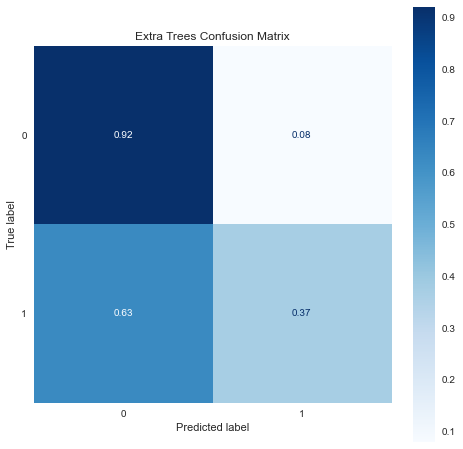

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(tuned_et_pipeline, X_test, y_test, ax=ax, normalize='true', cmap='Blues')
plt.title('Extra Trees Confusion Matrix')
plt.grid(False)
plt.show()

# Gradient Boosting

In [ ]:
gb_model = GradientBoostingClassifier(random_state=112221)

gb_pipeline = Pipeline(steps=[('tfidf', tfidf), ('gb', gb_model)])
gb_pipeline.fit(X_train, y_train)

gb_y_pred = gb_pipeline.predict(X_test)
accuracy_score(y_test, gb_y_pred)

In [ ]:
gb_grid = {
    'gb__loss': ['deviance', 'exponential'],
    'gb__n_estimators':[10, 30, 100],
    'gb__criterion':['friedman_mse', 'squared_error'],
    'gb__max_depth':[2, 6, 10],
    'gb__min_samples_split':[5, 10],
    'gb__min_samples_leaf':[3, 6]
}

gb_gridsearch = GridSearchCV(estimator=gb_pipeline, param_grid=gb_grid, scoring='accuracy', cv=5)
gb_gridsearch.fit(X_train, y_train)

print(f'Cross validation scores: {gb_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {gb_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {gb_gridsearch.best_params_}')

In [ ]:
gb_tuned_grid = {
    'gb__loss': ['deviance', 'exponential'],
    'gb__n_estimators':[10, 30, 100],
    'gb__criterion':['friedman_mse', 'squared_error'],
    'gb__max_depth':[2, 6, 10],
    'gb__min_samples_split':[5, 10],
    'gb__min_samples_leaf':[3, 6]
}

gb_tuned_gridsearch = GridSearchCV(estimator=gb_pipeline, param_grid=gb_tuned_grid, scoring='accuracy', cv=5)
gb_tuned_gridsearch.fit(X_train, y_train)

print(f'Cross validation scores: {gb_tuned_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {gb_tuned_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {gb_tuned_gridsearch.best_params_}')

In [ ]:
tuned_gb_model = GradientBoostingClassifier(max_depth=15, min_samples_leaf=3, min_samples_split=10, splitter='random', random_state=112221)

tuned_gb_pipeline = Pipeline(steps=[('tfidf', tfidf), ('tuned_et', tuned_gb_model)])
tuned_gb_pipeline.fit(X_train, y_train)

tuned_gb_y_pred = tuned_gb_pipeline.predict(X_test)
accuracy_score(y_test, tuned_gb_y_pred)

# Stochastic Gradient Descent

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
sgd_model = SGDClassifier(random_state=112221)

sgd_pipeline = Pipeline(steps=[('tfidf', tfidf), ('sgd', sgd_model)])
sgd_pipeline.fit(X_train, y_train)

sgd_y_pred = sgd_pipeline.predict(X_test)
accuracy_score(y_test, sgd_y_pred)

In [ ]:
sgd_grid = {
    'gb__loss': ['deviance', 'exponential'],
    'gb__n_estimators':[10, 30, 100],
    'gb__criterion':['friedman_mse', 'squared_error'],
    'gb__max_depth':[2, 6, 10],
    'gb__min_samples_split':[5, 10],
    'gb__min_samples_leaf':[3, 6]
}

sgd_gridsearch = GridSearchCV(estimator=sgd_pipeline, param_grid=sgd_grid, scoring='accuracy', cv=5)
sgd_gridsearch.fit(X_train, y_train)

print(f'Cross validation scores: {sgd_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {sgd_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {sgd_gridsearch.best_params_}')

In [ ]:
tuned_sgd_model = SGDClassifier(max_depth=15, min_samples_leaf=3, min_samples_split=10, splitter='random', random_state=112221)

tuned_sgd_pipeline = Pipeline(steps=[('tfidf', tfidf), ('tuned_et', tuned_sgd_model)])
tuned_sgd_pipeline.fit(X_train, y_train)

tuned_sgd_y_pred = tuned_sgd_pipeline.predict(X_test)
accuracy_score(y_test, tuned_sgd_y_pred)